# BBVA

## Importar librerías

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import math
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [8]:
# 1. leer normal (una sola cabecera)
df = pd.read_csv("../csv/bbva_data.csv")

# 2. eliminar las filas “raras” (las 2 primeras)
df = df[~df["Price"].isin(["Ticker", "Date"])].copy()

# 3. renombrar la primera columna porque en realidad es la fecha
df = df.rename(columns={"Price": "Date"})

# 4. convertir la fecha
df["Date"] = pd.to_datetime(df["Date"])

# 5. convertir el resto a numérico
for col in ["Close", "High", "Low", "Open", "Volume"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")


# Para ser coherentes con lo anterior, creamos una columna PRICE fija:
df["Price"] = pd.to_numeric(df["Close"], errors="coerce")

# ordenar por fecha
df = df.sort_values("Date").reset_index(drop=True)

print(df.head())
print(df.dtypes)



        Date     Close      High       Low      Open    Volume     Price
0 2000-01-03  4.115111  4.155740  4.106405  4.135426   8244257  4.115111
1 2000-01-04  4.007734  4.088991  3.993224  4.062873   8522096  4.007734
2 2000-01-05  3.917770  3.990321  3.900358  3.970007  12159826  3.917770
3 2000-01-06  3.917770  3.917770  3.917770  3.917770         0  3.917770
4 2000-01-07  3.967108  4.001932  3.926479  4.001932  62261944  3.967108
Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
Price            float64
dtype: object


## PREPROCESAMIENTO

In [9]:
def preparar_datos_desde_df(df, col_target="Price", window_size=30):
    df = df.sort_values("Date").reset_index(drop=True)

    if col_target not in df.columns:
        raise ValueError(f"No encuentro la columna {col_target}. Tengo: {df.columns.tolist()}")

    valores = df[[col_target]].values.astype(float)

    scaler = MinMaxScaler(feature_range=(0, 1))
    valores_scaled = scaler.fit_transform(valores)

    X, y = [], []
    for i in range(window_size, len(valores_scaled)):
        X.append(valores_scaled[i-window_size:i, 0])
        y.append(valores_scaled[i, 0])

    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y, scaler, df

window_size = 30
X_bbva, y_bbva, scaler_bbva, bbva_df = preparar_datos_desde_df(df, col_target="Price", window_size=window_size)

print("X_bbva:", X_bbva.shape)
print("y_bbva:", y_bbva.shape)



X_bbva: (6604, 30, 1)
y_bbva: (6604,)


## Train y test temporal

In [10]:
# 80% train, 20% test (temporal, sin shuffle)
train_size = int(len(X_bbva) * 0.8)
X_train, X_test = X_bbva[:train_size], X_bbva[train_size:]
y_train, y_test = y_bbva[:train_size], y_bbva[train_size:]

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (5283, 30, 1) (5283,)
Test : (1321, 30, 1) (1321,)


## Modelos

In [11]:
input_shape = (window_size, 1)

def build_rnn():
    model = Sequential([
        SimpleRNN(64, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

def build_lstm():
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

def build_gru():
    model = Sequential([
        GRU(64, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model


## Entrenamiento

In [12]:
EPOCHS = 1000
BATCH = 32

# Crear carpeta 'modelos' fuera de notebooks si no existe
modelos_dir = os.path.join("..", "modelos")
os.makedirs(modelos_dir, exist_ok=True)

# Callbacks comunes
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=80,             # se detiene si 80 epochs sin mejorar
    restore_best_weights=True
)

def entrenar_modelo(nombre, build_fn, X_train, y_train, X_test, y_test):
    """
    Entrena un modelo (RNN, LSTM o GRU) con EarlyStopping y ModelCheckpoint
    """
    print(f"\nEntrenando modelo {nombre}...\n")
    model = build_fn()

    # Ruta completa donde guardar el modelo
    model_path = os.path.join(modelos_dir, f"mejor_{nombre.lower()}_bbva.h5")

    checkpoint = ModelCheckpoint(
        model_path,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH,
        validation_data=(X_test, y_test),
        callbacks=[early_stop, checkpoint],
        verbose=1
    )
    return model, history

# ==============================
# ENTRENAR LOS TRES
# ==============================

rnn_model,  hist_rnn  = entrenar_modelo("RNN",  build_rnn,  X_train, y_train, X_test, y_test)
lstm_model, hist_lstm = entrenar_modelo("LSTM", build_lstm, X_train, y_train, X_test, y_test)
gru_model,  hist_gru  = entrenar_modelo("GRU",  build_gru,  X_train, y_train, X_test, y_test)



Entrenando modelo RNN...

Epoch 1/1000


c:\Users\Usuario\OneDrive\Documentos\GitHub\Aprendizaje_Automatico\env11\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026
Epoch 1: val_loss improved from None to 0.00374, saving model to ..\modelos\mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.0162e-04 - val_loss: 0.0037
Epoch 2/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7528e-05
Epoch 2: val_loss improved from 0.00374 to 0.00214, saving model to ..\modelos\mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.5185e-05 - val_loss: 0.0021
Epoch 3/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.6510e-05
Epoch 3: val_loss improved from 0.00214 to 0.00165, saving model to ..\modelos\mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.8266e-05 - val_loss: 0.0017
Epoch 4/1000
153/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.9142e-05
Epoch 4: val_loss improved from 0.00165 to 0.00126, saving model to ..\modelos\mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.9075e-05 - val_loss: 0.0013
Epoch 5/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7795e-05
Epoch 5: val_loss improved from 0.00126 to 0.00102, saving model to ..\modelos\mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.6286e-05 - val_loss: 0.0010
Epoch 6/1000
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2413e-05
Epoch 6: val_loss improved from 0.00102 to 0.00091, saving model to ..\modelos\mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.3919e-05 - val_loss: 9.0693e-04
Epoch 7/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6694e-05
Epoch 7: val_loss did not improve from 0.00091
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.6529e-05 - val_loss: 0.0011
Epoch 8/1000
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2651e-05
Epoch 8: val_loss improved from 0.00091 to 0.00067, saving model to ..\modelos\mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.0922e-05 - val_loss: 6.7267e-04
Epoch 9/1000
158/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1032e-05
Epoch 9: val_loss did not improve from 0.00067
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.0683e-05 - val_loss: 7.2558e-04
Epoch 10/1000
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6834e-05
Epoch 10: val_loss improved from 0.00067 to 0.00063, saving model to ..\modelos\mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.9786e-05 - val_loss: 6.2766e-04
Epoch 11/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3822e-05
Epoch 11: val_loss improved from 0.00063 to 0.00047, saving model to ..\modelos\mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.4470e-05 - val_loss: 4.6988e-04
Epoch 12/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1017e-05
Epoch 12: val_loss improved from 0.00047 to 0.00040, saving model to ..\modelos\mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.0776e-05 - val_loss: 4.0466e-04
Epoch 13/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1127e-05
Epoch 13: val_loss improved from 0.00040 to 0.00031, saving model to ..\modelos\mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.9922e-05 - val_loss: 3.0800e-04
Epoch 14/1000
153/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8646e-05
Epoch 14: val_loss improved from 0.00031 to 0.00028, saving model to ..\modelos\mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.9213e-05 - val_loss: 2.7868e-04
Epoch 15/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7587e-05
Epoch 15: val_loss improved from 0.00028 to 0.00027, saving model to ..\modelos\mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.7091e-05 - val_loss: 2.7297e-04
Epoch 16/1000
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5530e-05
Epoch 16: val_loss did not improve from 0.00027
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.5737e-05 - val_loss: 5.1550e-04
Epoch 17/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7793e-05
Epoch 17: val_loss did not improve from 0.00027
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.4435e-05 - val_loss: 3.2055e-04
Epoch 18/1000
155/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2686e-05
Epoch 18: val_loss improved from 0.00027 to 0.00015, saving model to ..\modelos\mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.3396e-05 - val_loss: 1.5466e-04
Epoch 19/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4318e-05
Epoch 19: val_loss did not improve from 0.00015
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.4725e-05 - val_loss: 1.8911e-04
Epoch 20/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2189e-05
Epoch 20: val_loss did not improve from 0.00015
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2454e-05 - val_loss: 1.7565e-04
Epoch 21/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9826e-05
Epoch 21: val_loss did not improve from 0.00015
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0754e-05 - val_loss: 1.9064e-04
Epoch 22/1000
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0804e-05
Epoch 22: val_loss improved from 0.00015 to 0.00015, saving model to ..\modelos\mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0821e-05 - val_loss: 1.4673e-04
Epoch 23/1000
158/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8584e-05
Epoch 23: val_loss did not improve from 0.00015
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.0366e-05 - val_loss: 3.5523e-04
Epoch 24/1000
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0211e-05
Epoch 24: val_loss did not improve from 0.00015
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0011e-05 - val_loss: 2.4703e-04
Epoch 25/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0631e-05
Epoch 25: val_loss improved from 0.00015 to 0.00012, saving model to ..\modelos\mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0160e-05 - val_loss: 1.1910e-04
Epoch 26/1000
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9102e-05
Epoch 26: val_loss did not improve from 0.00012
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1020e-05 - val_loss: 2.2977e-04
Epoch 27/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3000e-05
Epoch 27: val_loss did not improve from 0.00012
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1396e-05 - val_loss: 1.6848e-04
Epoch 28/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7303e-05
Epoch 28: val_loss did not improve from 0.00012
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9249e-05 - val_loss: 1.4847e-04
Epoch 29/1000
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9630e-05
Epoch 29: val_loss did not improve from 0.00012
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.9607e-05 - val_loss: 1.4385e-04
Epoch 30/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2785e-05
Epoch 30: val_loss did 

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.3930e-05 - val_loss: 9.8109e-05
Epoch 32/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8221e-05
Epoch 32: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.7928e-05 - val_loss: 1.5517e-04
Epoch 33/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1837e-05
Epoch 33: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0557e-05 - val_loss: 1.1960e-04
Epoch 34/1000
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5682e-05
Epoch 34: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.7953e-05 - val_loss: 1.1407e-04
Epoch 35/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7665e-05
Epoch 35: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9687e-05 - val_loss: 1.1897e-04
Epoch 36/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2380e-05
Epoch 36: val_loss did 

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8239e-05 - val_loss: 9.3579e-05
Epoch 40/1000
158/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3787e-05
Epoch 40: val_loss improved from 0.00009 to 0.00009, saving model to ..\modelos\mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.0415e-05 - val_loss: 9.3414e-05
Epoch 41/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8049e-05
Epoch 41: val_loss improved from 0.00009 to 0.00009, saving model to ..\modelos\mejor_rnn_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8171e-05 - val_loss: 9.0688e-05
Epoch 42/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7664e-05
Epoch 42: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0447e-05 - val_loss: 1.3433e-04
Epoch 43/1000
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5089e-05
Epoch 43: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9031e-05 - val_loss: 1.8835e-04
Epoch 44/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1068e-05
Epoch 44: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8982e-05 - val_loss: 1.1097e-04
Epoch 45/1000
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7560e-05
Epoch 45: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8041e-05 - val_loss: 9.9817e-05
Epoch 46/1000
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0993e-05
Epoch 46: val_loss did 

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8189e-05 - val_loss: 8.9737e-05
Epoch 62/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0027e-05
Epoch 62: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8739e-05 - val_loss: 1.6380e-04
Epoch 63/1000
158/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2358e-05
Epoch 63: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8827e-05 - val_loss: 1.0636e-04
Epoch 64/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1846e-05
Epoch 64: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7626e-05 - val_loss: 1.3280e-04
Epoch 65/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8364e-05
Epoch 65: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7227e-05 - val_loss: 9.0689e-05
Epoch 66/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8232e-05
Epoch 66: val_loss did 

166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0013 - val_loss: 9.6626e-04
Epoch 2/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2790e-04
Epoch 2: val_loss improved from 0.00097 to 0.00039, saving model to ..\modelos\mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.2087e-04 - val_loss: 3.9163e-04
Epoch 3/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2619e-04
Epoch 3: val_loss improved from 0.00039 to 0.00039, saving model to ..\modelos\mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.1018e-04 - val_loss: 3.8636e-04
Epoch 4/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0507e-04
Epoch 4: val_loss did not improve from 0.00039
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 9.8485e-05 - val_loss: 4.6640e-04
Epoch 5/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0002e-04
Epoch 5: val_loss improved from 0.00039 to 0.00032, saving model to ..\modelos\mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 9.0991e-05 - val_loss: 3.1897e-04
Epoch 6/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.5441e-05
Epoch 6: val_loss improved from 0.00032 to 0.00031, saving model to ..\modelos\mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 8.2385e-05 - val_loss: 3.0746e-04
Epoch 7/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.8894e-05
Epoch 7: val_loss improved from 0.00031 to 0.00023, saving model to ..\modelos\mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 7.7505e-05 - val_loss: 2.2957e-04
Epoch 8/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9984e-05
Epoch 8: val_loss did not improve from 0.00023
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7.1780e-05 - val_loss: 2.4918e-04
Epoch 9/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9155e-05
Epoch 9: val_loss did not improve from 0.00023
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 6.7943e-05 - val_loss: 2.4047e-04
Epoch 10/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4328e-05
Epoch 10: val_loss did not improve from 0.00023
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 6.4980e-05 - val_loss: 2.4646e-04
Epoch 11/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5301e-05
Epoch 11: val_loss improved from 0.00023 to 0.00019, saving model to ..\modelos\mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6.4734e-05 - val_loss: 1.9375e-04
Epoch 12/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.3621e-05
Epoch 12: val_loss improved from 0.00019 to 0.00016, saving model to ..\modelos\mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 6.1507e-05 - val_loss: 1.5612e-04
Epoch 13/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.2713e-05
Epoch 13: val_loss did not improve from 0.00016
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.9619e-05 - val_loss: 1.5614e-04
Epoch 14/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5118e-05
Epoch 14: val_loss improved from 0.00016 to 0.00015, saving model to ..\modelos\mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5.4236e-05 - val_loss: 1.4626e-04
Epoch 15/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3050e-05
Epoch 15: val_loss improved from 0.00015 to 0.00014, saving model to ..\modelos\mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.3284e-05 - val_loss: 1.3645e-04
Epoch 16/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1377e-05
Epoch 16: val_loss did not improve from 0.00014
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5.1088e-05 - val_loss: 1.4454e-04
Epoch 17/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9189e-05
Epoch 17: val_loss improved from 0.00014 to 0.00013, saving model to ..\modelos\mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.7279e-05 - val_loss: 1.2767e-04
Epoch 18/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5874e-05
Epoch 18: val_loss improved from 0.00013 to 0.00012, saving model to ..\modelos\mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.4681e-05 - val_loss: 1.1950e-04
Epoch 19/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6312e-05
Epoch 19: val_loss did not improve from 0.00012
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.4748e-05 - val_loss: 1.3854e-04
Epoch 20/1000
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7648e-05
Epoch 20: val_loss improved from 0.00012 to 0.00011, saving model to ..\modelos\mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.3977e-05 - val_loss: 1.1446e-04
Epoch 21/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.8873e-05
Epoch 21: val_loss improved from 0.00011 to 0.00010, saving model to ..\modelos\mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.0122e-05 - val_loss: 1.0440e-04
Epoch 22/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6490e-05
Epoch 22: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.6992e-05 - val_loss: 1.0441e-04
Epoch 23/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4980e-05
Epoch 23: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.5702e-05 - val_loss: 1.0552e-04
Epoch 24/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.2327e-05
Epoch 24: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.3889e-05 - val_loss: 1.2180e-04
Epoch 25/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4679e-05
Epoch 25: val_loss improved from 0.00010 to 0.00009, saving model to ..\modelos\mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.3698e-05 - val_loss: 9.0768e-05
Epoch 26/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0375e-05
Epoch 26: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1522e-05 - val_loss: 1.2901e-04
Epoch 27/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.1042e-05
Epoch 27: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.2236e-05 - val_loss: 1.2312e-04
Epoch 28/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0151e-05
Epoch 28: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.9773e-05 - val_loss: 1.1134e-04
Epoch 29/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.0506e-05
Epoch 29: val_loss improved from 0.00009 to 0.00009, saving model to ..\modelos\mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.0700e-05 - val_loss: 8.6516e-05
Epoch 30/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0798e-05
Epoch 30: val_loss improved from 0.00009 to 0.00008, saving model to ..\modelos\mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.9281e-05 - val_loss: 8.2991e-05
Epoch 31/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8765e-05 
Epoch 31: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.8900e-05 - val_loss: 9.6356e-05
Epoch 32/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7293e-05
Epoch 32: val_loss improved from 0.00008 to 0.00008, saving model to ..\modelos\mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.8322e-05 - val_loss: 8.2897e-05
Epoch 33/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9036e-05
Epoch 33: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.8438e-05 - val_loss: 9.0006e-05
Epoch 34/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7704e-05
Epoch 34: val_loss improved from 0.00008 to 0.00008, saving model to ..\modelos\mejor_lstm_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.7928e-05 - val_loss: 8.1679e-05
Epoch 35/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9693e-05
Epoch 35: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.9241e-05 - val_loss: 8.7801e-05
Epoch 36/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9515e-05
Epoch 36: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.9896e-05 - val_loss: 9.0543e-05
Epoch 37/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8242e-05
Epoch 37: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.8439e-05 - val_loss: 9.2156e-05
Epoch 38/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7512e-05
Epoch 38: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.8377e-05 - val_loss: 8.2478e-05
Epoch 39/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.0077e-05
Epoch 39: val_

166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 8.4354e-04 - val_loss: 1.6733e-04
Epoch 2/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3822e-05
Epoch 2: val_loss improved from 0.00017 to 0.00015, saving model to ..\modelos\mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 5.3470e-05 - val_loss: 1.4665e-04
Epoch 3/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5006e-05
Epoch 3: val_loss did not improve from 0.00015
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.6899e-05 - val_loss: 1.6568e-04
Epoch 4/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4513e-05
Epoch 4: val_loss improved from 0.00015 to 0.00013, saving model to ..\modelos\mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.4295e-05 - val_loss: 1.3161e-04
Epoch 5/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.2372e-05
Epoch 5: val_loss improved from 0.00013 to 0.00012, saving model to ..\modelos\mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.0554e-05 - val_loss: 1.1523e-04
Epoch 6/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8768e-05
Epoch 6: val_loss did not improve from 0.00012
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.9078e-05 - val_loss: 1.3954e-04
Epoch 7/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.7239e-05
Epoch 7: val_loss improved from 0.00012 to 0.00011, saving model to ..\modelos\mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.6509e-05 - val_loss: 1.0662e-04
Epoch 8/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6465e-05
Epoch 8: val_loss improved from 0.00011 to 0.00010, saving model to ..\modelos\mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.6342e-05 - val_loss: 9.9515e-05
Epoch 9/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.4789e-05
Epoch 9: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.5125e-05 - val_loss: 1.2586e-04
Epoch 10/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5526e-05
Epoch 10: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.3953e-05 - val_loss: 1.0267e-04
Epoch 11/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3439e-05
Epoch 11: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.2652e-05 - val_loss: 1.5055e-04
Epoch 12/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6266e-05
Epoch 12: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.3744e-05 - val_loss: 1.2907e-04
Epoch 13/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2285e-05
Epoch 13: val_l

166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1249e-05 - val_loss: 8.9944e-05
Epoch 14/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1549e-05
Epoch 14: val_loss improved from 0.00009 to 0.00009, saving model to ..\modelos\mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1661e-05 - val_loss: 8.8589e-05
Epoch 15/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8411e-05
Epoch 15: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.9965e-05 - val_loss: 1.2768e-04
Epoch 16/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2001e-05
Epoch 16: val_loss improved from 0.00009 to 0.00008, saving model to ..\modelos\mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.0676e-05 - val_loss: 8.4647e-05
Epoch 17/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.8779e-05
Epoch 17: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.9850e-05 - val_loss: 9.6244e-05
Epoch 18/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9618e-05
Epoch 18: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.9589e-05 - val_loss: 1.3812e-04
Epoch 19/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9348e-05
Epoch 19: val_loss improved from 0.00008 to 0.00008, saving model to ..\modelos\mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.0537e-05 - val_loss: 8.3882e-05
Epoch 20/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9762e-05
Epoch 20: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.9147e-05 - val_loss: 1.3946e-04
Epoch 21/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9416e-05
Epoch 21: val_loss improved from 0.00008 to 0.00008, saving model to ..\modelos\mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.8217e-05 - val_loss: 8.2592e-05
Epoch 22/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.8707e-05
Epoch 22: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.9161e-05 - val_loss: 1.1232e-04
Epoch 23/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3591e-05
Epoch 23: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.9104e-05 - val_loss: 8.6379e-05
Epoch 24/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0111e-05
Epoch 24: val_loss improved from 0.00008 to 0.00008, saving model to ..\modelos\mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.9683e-05 - val_loss: 8.1121e-05
Epoch 25/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.3470e-05
Epoch 25: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.0422e-05 - val_loss: 8.7706e-05
Epoch 26/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8875e-05
Epoch 26: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.8826e-05 - val_loss: 8.7140e-05
Epoch 27/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.7880e-05
Epoch 27: val_loss improved from 0.00008 to 0.00008, saving model to ..\modelos\mejor_gru_bbva.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.8940e-05 - val_loss: 8.0713e-05
Epoch 28/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9758e-05
Epoch 28: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.7577e-05 - val_loss: 8.1604e-05
Epoch 29/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9335e-05
Epoch 29: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.9935e-05 - val_loss: 8.1562e-05
Epoch 30/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8790e-05
Epoch 30: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.8695e-05 - val_loss: 9.8427e-05
Epoch 31/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.6838e-05
Epoch 31: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.8166e-05 - val_loss: 8.8246e-05
Epoch 32/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8037e-05
Epoch 32: val_

166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.8259e-05 - val_loss: 8.0708e-05
Epoch 86/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.5676e-05
Epoch 86: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.7288e-05 - val_loss: 8.4157e-05
Epoch 87/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6951e-05
Epoch 87: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.7636e-05 - val_loss: 1.3140e-04
Epoch 88/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8156e-05
Epoch 88: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.7209e-05 - val_loss: 8.3810e-05
Epoch 89/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6987e-05
Epoch 89: val_loss did not improve from 0.00008
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.7691e-05 - val_loss: 8.4976e-05
Epoch 90/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.7543e-05
Epoch 90: val

In [13]:
# todas con la misma forma de entrada
input_shape = (window_size, 1)

def build_rnn():
    model = Sequential([
        SimpleRNN(64, input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

def build_lstm():
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

def build_gru():
    model = Sequential([
        GRU(64, input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

## Predicciones

In [14]:
# predicciones (en escala 0-1)
y_pred_rnn  = rnn_model.predict(X_test)
y_pred_lstm = lstm_model.predict(X_test)
y_pred_gru  = gru_model.predict(X_test)

# desescalar
y_test_real = scaler_bbva.inverse_transform(y_test.reshape(-1, 1))
pred_rnn_real  = scaler_bbva.inverse_transform(y_pred_rnn)
pred_lstm_real = scaler_bbva.inverse_transform(y_pred_lstm)
pred_gru_real  = scaler_bbva.inverse_transform(y_pred_gru)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


## Métricas

In [15]:
def evaluar(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

mae_rnn, rmse_rnn   = evaluar(y_test_real, pred_rnn_real)
mae_lstm, rmse_lstm = evaluar(y_test_real, pred_lstm_real)
mae_gru, rmse_gru   = evaluar(y_test_real, pred_gru_real)

print("RNN  -> MAE:", mae_rnn,  "RMSE:", rmse_rnn)
print("LSTM -> MAE:", mae_lstm, "RMSE:", rmse_lstm)
print("GRU  -> MAE:", mae_gru,  "RMSE:", rmse_gru)


RNN  -> MAE: 0.09851737693798168 RMSE: 0.15093615260827586
LSTM -> MAE: 0.09432537071999048 RMSE: 0.14400011413301272
GRU  -> MAE: 0.09363835458950413 RMSE: 0.14314119179184034


# Graficar

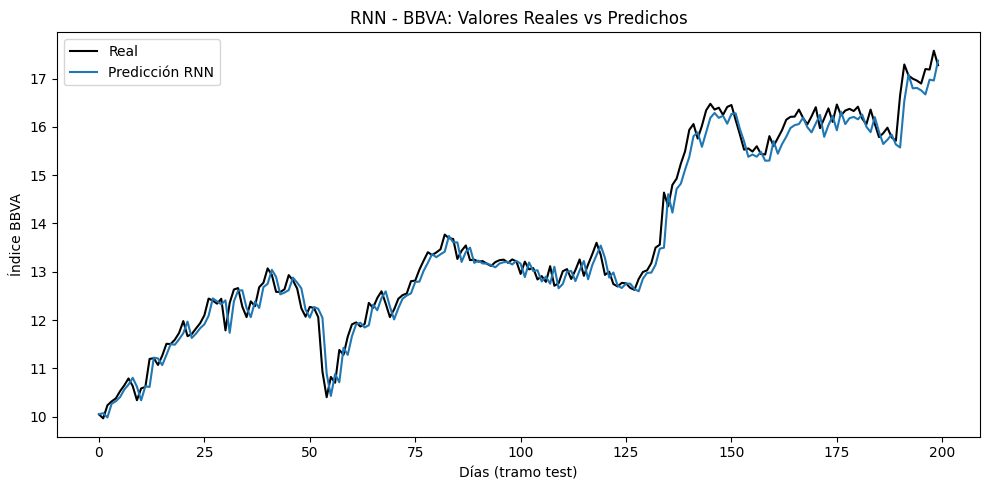

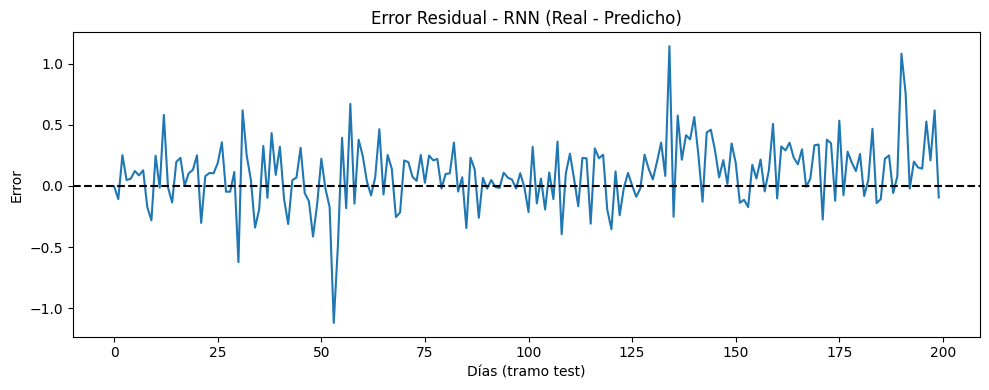

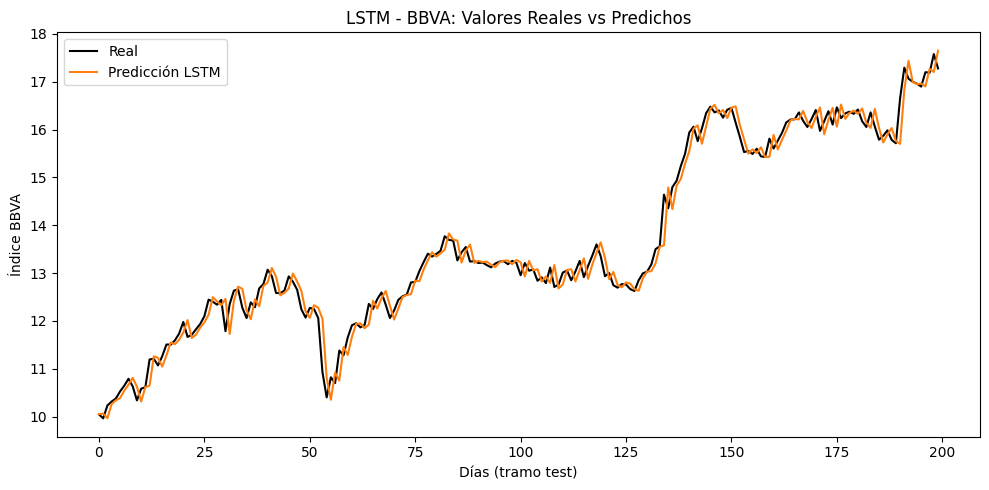

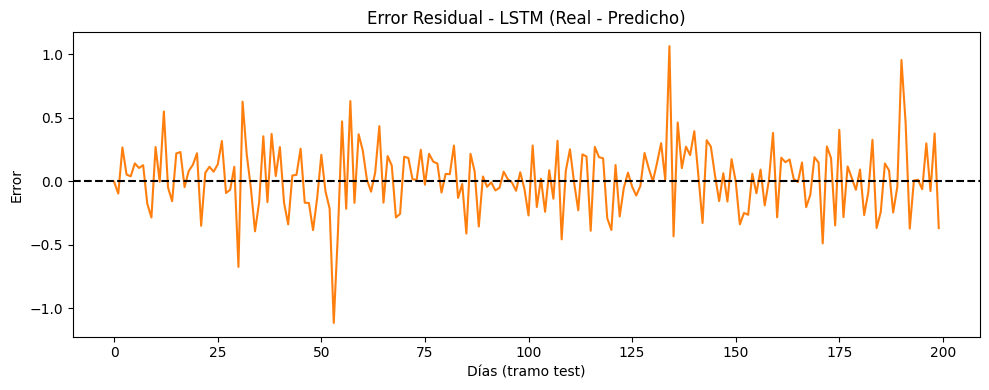

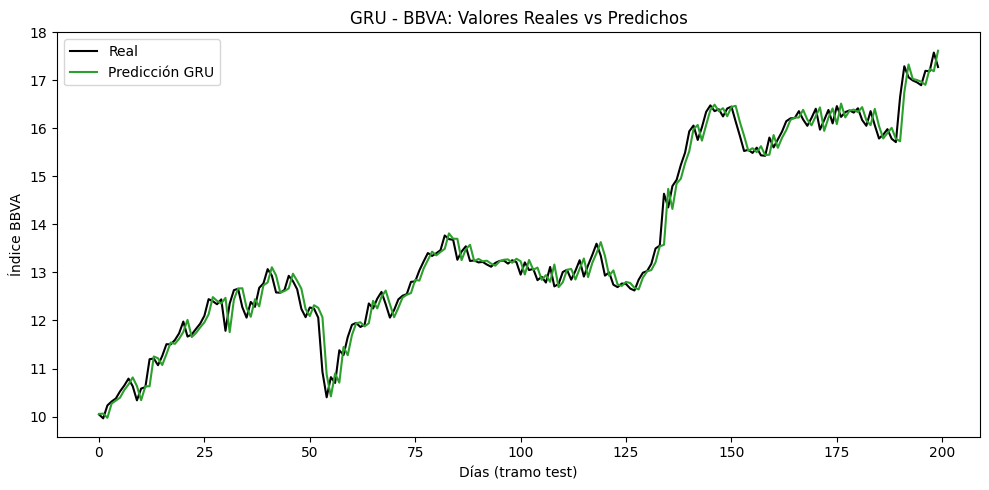

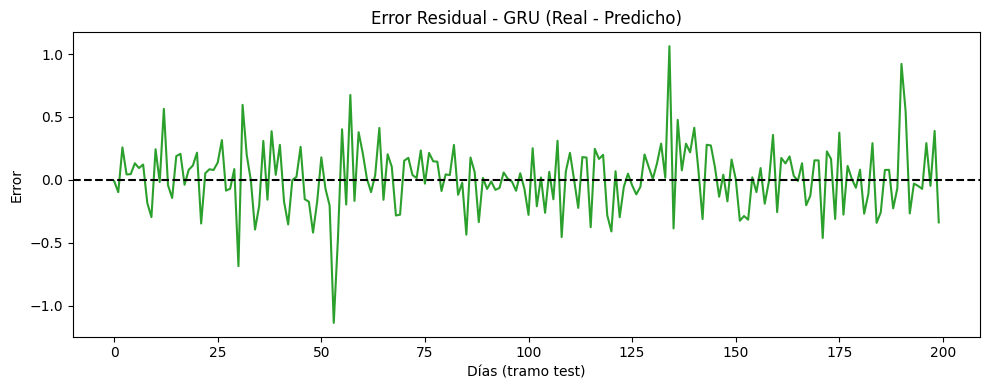

In [16]:
# --- Tramo a mostrar (últimos 200 días del test, por ejemplo) ---
n_mostrar = 200
y_real_plot = y_test_real[-n_mostrar:]
pred_rnn_plot  = pred_rnn_real[-n_mostrar:]
pred_lstm_plot = pred_lstm_real[-n_mostrar:]
pred_gru_plot  = pred_gru_real[-n_mostrar:]

# ===============================
# 1️⃣ RNN
# ===============================
plt.figure(figsize=(10,5))
plt.plot(y_real_plot, label="Real", color="black")
plt.plot(pred_rnn_plot, label="Predicción RNN", color="tab:blue")
plt.title("RNN - BBVA: Valores Reales vs Predichos")
plt.xlabel("Días (tramo test)")
plt.ylabel("Índice BBVA")
plt.legend()
plt.tight_layout()
plt.show()

# --- Error RNN ---
plt.figure(figsize=(10,4))
plt.plot(y_real_plot - pred_rnn_plot, color="tab:blue")
plt.axhline(0, color="black", linestyle="--")
plt.title("Error Residual - RNN (Real - Predicho)")
plt.xlabel("Días (tramo test)")
plt.ylabel("Error")
plt.tight_layout()
plt.show()

# ===============================
# 2️⃣ LSTM
# ===============================
plt.figure(figsize=(10,5))
plt.plot(y_real_plot, label="Real", color="black")
plt.plot(pred_lstm_plot, label="Predicción LSTM", color="tab:orange")
plt.title("LSTM - BBVA: Valores Reales vs Predichos")
plt.xlabel("Días (tramo test)")
plt.ylabel("Índice BBVA")
plt.legend()
plt.tight_layout()
plt.show()

# --- Error LSTM ---
plt.figure(figsize=(10,4))
plt.plot(y_real_plot - pred_lstm_plot, color="tab:orange")
plt.axhline(0, color="black", linestyle="--")
plt.title("Error Residual - LSTM (Real - Predicho)")
plt.xlabel("Días (tramo test)")
plt.ylabel("Error")
plt.tight_layout()
plt.show()

# ===============================
# 3️⃣ GRU
# ===============================
plt.figure(figsize=(10,5))
plt.plot(y_real_plot, label="Real", color="black")
plt.plot(pred_gru_plot, label="Predicción GRU", color="tab:green")
plt.title("GRU - BBVA: Valores Reales vs Predichos")
plt.xlabel("Días (tramo test)")
plt.ylabel("Índice BBVA")
plt.legend()
plt.tight_layout()
plt.show()

# --- Error GRU ---
plt.figure(figsize=(10,4))
plt.plot(y_real_plot - pred_gru_plot, color="tab:green")
plt.axhline(0, color="black", linestyle="--")
plt.title("Error Residual - GRU (Real - Predicho)")
plt.xlabel("Días (tramo test)")
plt.ylabel("Error")
plt.tight_layout()
plt.show()


In [17]:
def predecir_siguiente(model, df_original, scaler, col_target="Price", window_size=30):
    # usamos el df limpio que tenías: bbva_df
    ultimos = df_original[[col_target]].values.astype(float)[-window_size:]
    ultimos_scaled = scaler.transform(ultimos)
    X_input = ultimos_scaled.reshape((1, window_size, 1))
    pred_scaled = model.predict(X_input)
    pred = scaler.inverse_transform(pred_scaled)
    return pred[0,0]

pred_manana_lstm = predecir_siguiente(lstm_model, bbva_df, scaler_bbva, col_target="Price", window_size=window_size)
print("Predicción BBVA próximo día (LSTM):", pred_manana_lstm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicción BBVA próximo día (LSTM): 17.231998


## Predecir dias futuros

In [18]:
def predecir_n_dias(model, df_original, scaler, col_target="Price", window_size=30, n_dias=7):
    # 1. cogemos los últimos window_size valores reales
    serie = df_original[[col_target]].values.astype(float)
    ultimos = serie[-window_size:]  # shape (30, 1)

    # los pasamos a escala
    ultimos_scaled = scaler.transform(ultimos)

    preds_desescaladas = []

    # trabajamos en una copia que iremos ampliando
    ventana_actual = ultimos_scaled.copy()  # shape (30,1)

    for _ in range(n_dias):
        # (1, pasos, 1)
        X_input = ventana_actual.reshape((1, window_size, 1))
        pred_scaled = model.predict(X_input, verbose=0)
        # desescalar
        pred_real = scaler.inverse_transform(pred_scaled)[0, 0]
        preds_desescaladas.append(pred_real)

        # ahora actualizamos la ventana: quitamos el 1º y metemos la predicción al final
        nuevo_valor_scaled = pred_scaled  # shape (1,1)
        ventana_actual = np.vstack([ventana_actual[1:], nuevo_valor_scaled])

    return preds_desescaladas

In [19]:
# última fecha real
ultima_fecha = bbva_df["Date"].max()

# generamos 7 fechas a partir de la última
fechas_futuras = pd.date_range(start=ultima_fecha + pd.Timedelta(days=1),
                               periods=7, freq="B")  # "B" para días hábiles

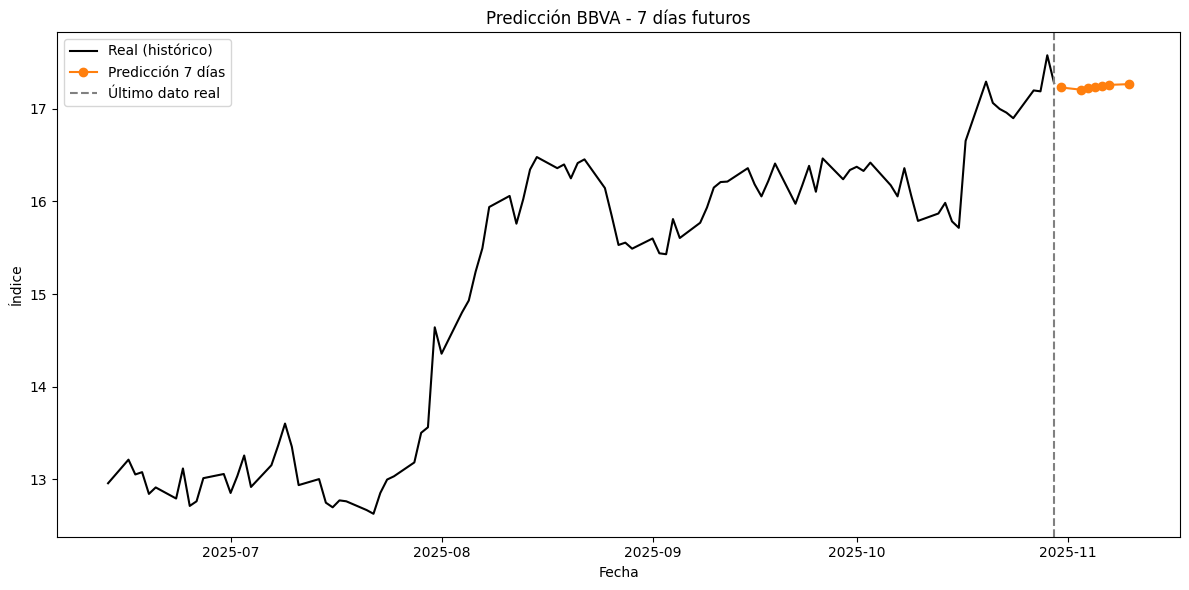

In [20]:
# 1) obtenemos las 7 predicciones
preds_7 = predecir_n_dias(lstm_model, bbva_df, scaler_bbva,
                          col_target="Price", window_size=window_size, n_dias=7)

# 2) hacemos un DataFrame de futuro
df_futuro = pd.DataFrame({
    "Date": fechas_futuras,
    "Predicted_Price": preds_7
})

# 3) para ver contexto, cogemos los últimos, por ejemplo, 100 días reales
historico_plot = bbva_df[["Date", "Price"]].tail(100).copy()

# 4) graficar
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# parte histórica
plt.plot(historico_plot["Date"], historico_plot["Price"], label="Real (histórico)", color="black")

# parte futura (solo predicción)
plt.plot(df_futuro["Date"], df_futuro["Predicted_Price"],
         label="Predicción 7 días", color="tab:orange", marker="o")

# marcar visualmente el corte
plt.axvline(historico_plot["Date"].max(), color="gray", linestyle="--", label="Último dato real")

plt.title("Predicción BBVA - 7 días futuros")
plt.xlabel("Fecha")
plt.ylabel("Índice")
plt.legend()
plt.tight_layout()
plt.show()
